In [2]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
from mlxtend.plotting import plot_decision_regions
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr
from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import (AdaBoostClassifier, GradientBoostingClassifier,
                              RandomForestClassifier)
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import permutation_importance
from sklearn.metrics import (accuracy_score, average_precision_score,
                             confusion_matrix, f1_score)
from sklearn.model_selection import (StratifiedKFold, permutation_test_score,
                                     train_test_split)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestRegressor

import seaborn as sns
from sklearn.preprocessing import StandardScaler


In [3]:
data = pd.read_csv('50_Startups.csv')
data.head()


,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


In [4]:
data.isna().sum()

R&D Spend          0
Administration     0
Marketing Spend    0
State              0
Profit             0
dtype: int64

***
Drop rows where entries are 0
***

In [5]:
data = data.drop(index=data[(data['Marketing Spend'] <= 0) | (data['Administration'] <= 0) |  (data['R&D Spend'] <= 0)].index)

<AxesSubplot:xlabel='Profit', ylabel='Count'>

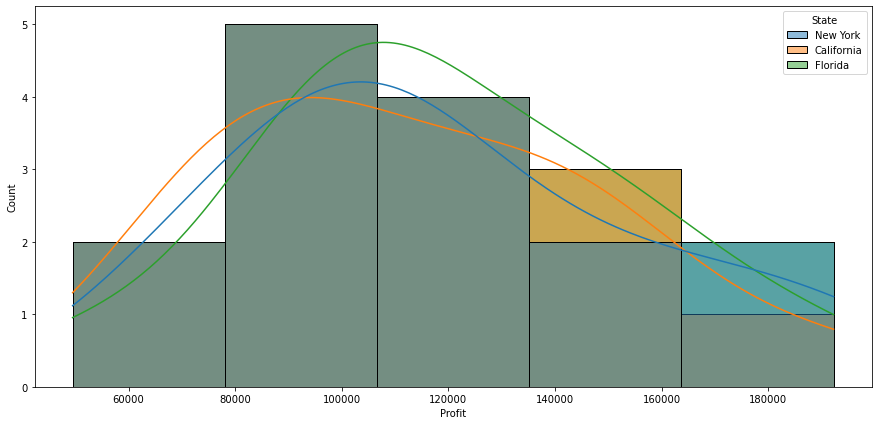

In [6]:
fig, ax = plt.subplots(figsize=(15,7))
sns.histplot(ax = ax, x='Profit', data=data, bins=5, hue='State', kde=True)

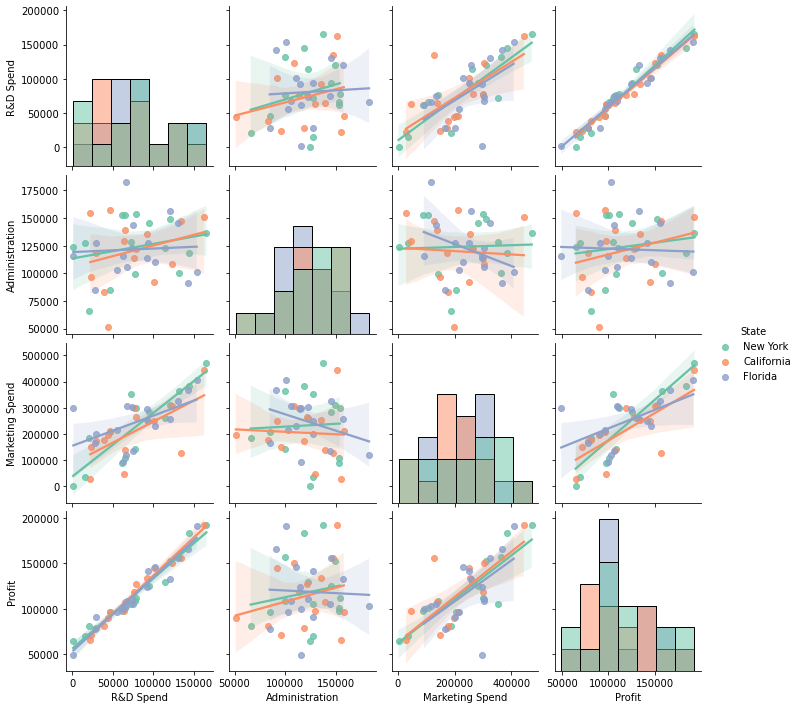

In [7]:
g = sns.pairplot(data, kind = 'reg', hue="State", palette="Set2", diag_kind="hist", height=2.5)

***
## R&D Spend and Marketing Spend has high correlation with profit.
## Admistration does not seem to have a strong correlation
## can be confirmed with a correlation table below
***

In [8]:
data.corr()

,R&D Spend,Administration,Marketing Spend,Profit
R&D Spend,1.000000,0.196068,0.708253,0.977703
Administration,0.196068,1.000000,-0.085831,0.135076
Marketing Spend,0.708253,-0.085831,1.000000,0.732277
Profit,0.977703,0.135076,0.732277,1.000000


***
## Lets check the expenses per state
***

In [9]:
outer_data = data.groupby('State').sum()
pct_data = outer_data.drop(['Profit'], axis=1).values
pct_data = data / data.sum(axis=1) * 100 # get percentages for spends for each state as aginst total spend
outer_data

C:\Users\vikas\anaconda3\envs\Python_3_7\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  This is separate from the ipykernel package so we can avoid doing imports until


,R&D Spend,Administration,Marketing Spend,Profit
State,,,,
California,1099180.46,1800279.90,3058022.74,1709146.85
Florida,1291584.26,1948302.36,3957176.82,1900384.39
New York,1208354.31,1860981.74,3490882.27,1775409.32


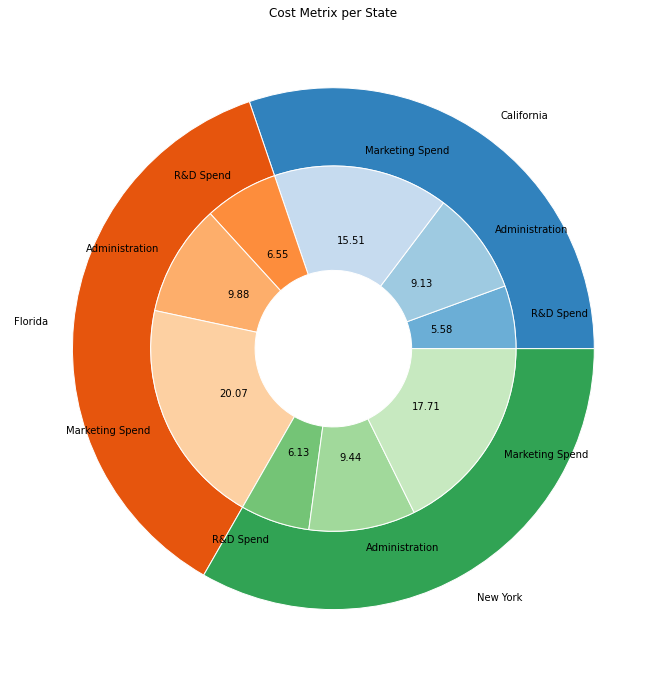

In [10]:
fig, ax = plt.subplots(figsize=(24,12))

size = 0.3

# outer_data = (100 * outer_data / outer_data.sum()).round(2)
# outer_data
inner_labels = outer_data.drop(['Profit'], axis=1).columns.values
inner_labels = np.concatenate((inner_labels, inner_labels, inner_labels))


cmap = plt.get_cmap("tab20c")
outer_colors = cmap(np.arange(3)*4)
inner_colors = cmap(np.array([1, 2, 3,  # color fading blue
                              5, 6, 7,  # color fading orange
                              9, 10, 11])) # color fading

ax.pie(outer_data.drop(['Profit'],axis=1).sum(axis=1).values, radius=1, colors=outer_colors, labels=outer_data.index.values,
       wedgeprops=dict(width=size, edgecolor='w'))

ax.pie(outer_data.drop(['Profit'],axis=1).values.flatten(), radius=1-size, colors=inner_colors, labels = inner_labels, autopct='%.2f',
       wedgeprops=dict(width=size+0.1, edgecolor='w'))

ax.set(aspect="equal", title='Cost Metrix per State')
plt.show()

***
### Spends are more on marketing followed by Administration and then R&D in sequence for all 3 states
***

In [117]:
X = data.drop(['Profit', 'State'], axis=1)
X = pd.concat([X, pd.get_dummies(data['State'])], axis=1)
y = data['Profit']


In [118]:
X.head(20)

,R&D Spend,Administration,Marketing Spend,California,Florida,New York
0,165349.20,136897.80,471784.10,0,0,1
1,162597.70,151377.59,443898.53,1,0,0
2,153441.51,101145.55,407934.54,0,1,0
3,144372.41,118671.85,383199.62,0,0,1
4,142107.34,91391.77,366168.42,0,1,0
5,131876.90,99814.71,362861.36,0,0,1
6,134615.46,147198.87,127716.82,1,0,0
7,130298.13,145530.06,323876.68,0,1,0
8,120542.52,148718.95,311613.29,0,0,1
9,123334.88,108679.17,304981.62,1,0,0


In [119]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [120]:
X_train.head()

,R&D Spend,Administration,Marketing Spend,California,Florida,New York
6,134615.46,147198.87,127716.82,1,0,0
25,64664.71,139553.16,137962.62,1,0,0
33,55493.95,103057.49,214634.81,0,1,0
20,76253.86,113867.30,298664.47,1,0,0
17,94657.16,145077.58,282574.31,0,0,1


In [121]:
# scaling
from sklearn.preprocessing import MinMaxScaler
scalar = MinMaxScaler()
scalar = scalar.fit(X_train)
X_train = scalar.transform(X_train)

X_test = scalar.transform(X_test)

In [122]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

In [123]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
print('Test scores: \n')
print('MAE:', mean_absolute_error(y_test,y_pred_test))
print('MSE:', mean_squared_error(y_test,y_pred_test))
print('RMSE:', np.sqrt(mean_squared_error(y_test,y_pred_test)))
print('R2:', r2_score(y_test,y_pred_test))

print('\n\nTrain scores: \n')
print('MAE:', mean_absolute_error(y_train,y_pred_train))
print('MSE:', mean_squared_error(y_train,y_pred_train))
print('RMSE:', np.sqrt(mean_squared_error(y_train,y_pred_train)))
print('R2:', r2_score(y_train,y_pred_train))

Test scores: 

MAE: 8201.719076765741
MSE: 97276375.31176254
RMSE: 9862.878652389603
R2: 0.9385926603836594


Train scores: 

MAE: 5018.492459201307
MSE: 38104076.22784139
RMSE: 6172.849927532776
R2: 0.9675955248072912


***
### Both R2 scores are good but lets check with RandomForest
***

In [136]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(max_depth=2, n_estimators=5, random_state=10, ccp_alpha=0.1)
model.fit(X_train, y_train)
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

In [137]:
print('Test scores: \n')
print('MAE:', mean_absolute_error(y_test,y_pred_test))
print('MSE:', mean_squared_error(y_test,y_pred_test))
print('RMSE:', np.sqrt(mean_squared_error(y_test,y_pred_test)))
print('R2:', r2_score(y_test,y_pred_test))

print('\n\nTrain scores: \n')
print('MAE:', mean_absolute_error(y_train,y_pred_train))
print('MSE:', mean_squared_error(y_train,y_pred_train))
print('RMSE:', np.sqrt(mean_squared_error(y_train,y_pred_train)))
print('R2:', r2_score(y_train,y_pred_train))

Test scores: 

MAE: 9837.940816378461
MSE: 126088641.76988935
RMSE: 11228.919884382885
R2: 0.920404435073657


Train scores: 

MAE: 6659.67057381866
MSE: 94995867.7128493
RMSE: 9746.582360645669
R2: 0.9192135975084558


***
### We have test R2score > train R2score > CL(0.75...agreed SL = 0.25)
### Choosing this model for deployment
***